# EE379K Final Project
# An Experiment on Speed Dating
### Abigail Johnson, Jeremy Shahan, Raymond Wen, Jacob Williamson

In [165]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.linear_model as regression
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib inline


##### I. Some preliminary exploration...

In [166]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df = pd.read_csv('data/speed_dating.csv', encoding="ISO-8859-1")
print (df.head())
print (df.describe())


   iid   id  gender  idg  condtn  wave  round  position  positin1  order  \
0    1  1.0       0    1       1     1     10         7       NaN      4   
1    1  1.0       0    1       1     1     10         7       NaN      3   
2    1  1.0       0    1       1     1     10         7       NaN     10   
3    1  1.0       0    1       1     1     10         7       NaN      5   
4    1  1.0       0    1       1     1     10         7       NaN      7   

   partner   pid  match  int_corr  samerace  age_o  race_o  pf_o_att  \
0        1  11.0      0      0.14         0   27.0     2.0      35.0   
1        2  12.0      0      0.54         0   22.0     2.0      60.0   
2        3  13.0      1      0.16         1   22.0     4.0      19.0   
3        4  14.0      1      0.61         0   23.0     2.0      30.0   
4        5  15.0      1      0.21         0   24.0     3.0      30.0   

   pf_o_sin  pf_o_int  pf_o_fun  pf_o_amb  pf_o_sha  dec_o  attr_o  sinc_o  \
0      20.0      20.0      20.0 

##### Females: which features are most significant ?

In [167]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

input_vars = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']

# female model
f = df.loc[df.gender == 0, :]
f_data = f.copy()
f_data = f.dropna(subset=input_vars)
f_model = sm.OLS(f_data.dec, sm.add_constant(f_data.loc[:, input_vars]))
f_results = f_model.fit()
print(f_results.params, "\n")
print("P-values (Women) :\n" , f_results.pvalues, "\n" ) 
# all p-values are less than 0.05 which means all of features are significant in the model.

# Now let's rank the features based on their importance in the model using RFE method, for women.
estimator = SVC(kernel= "linear", C=0.1)
selector = RFE(estimator,1)
cfl=selector.fit(f_data.loc[:, input_vars], f_data.dec)
ranking_f=cfl.ranking_
feature_ranking_f=zip(ranking_f, input_vars)
print("Ranked Feature Importance (Women):\n")
list(feature_ranking_f)

(const   -0.395832
attr     0.049571
sinc    -0.024828
intel    0.010104
fun      0.020365
amb     -0.020752
shar     0.023560
like     0.061468
prob     0.018177
dtype: float64, '\n')
('P-values (Women) :\n', const    3.024043e-28
attr     3.585211e-24
sinc     4.757680e-06
intel    1.412131e-01
fun      1.578416e-04
amb      5.948697e-05
shar     4.867489e-07
like     5.096468e-21
prob     1.299559e-06
dtype: float64, '\n')
Ranked Feature Importance (Women):



[(2, 'attr'),
 (6, 'sinc'),
 (8, 'intel'),
 (3, 'fun'),
 (4, 'amb'),
 (5, 'shar'),
 (1, 'like'),
 (7, 'prob')]

##### Males: which features are most significant ?

In [168]:
# female model
f = df.loc[df.gender == 1, :]
f_data = f.copy()
f_data = f.dropna(subset=input_vars)
f_model = sm.OLS(f_data.dec, sm.add_constant(f_data.loc[:, input_vars]))
f_results = f_model.fit()
print(f_results.params, "\n")
print("P-values (Men) :\n" , f_results.pvalues, "\n" ) 
# all p-values are less than 0.05 which means all of features are significant in the model.

# Now let's rank the features based on their importance in the model using RFE method, for women.
estimator = SVC(kernel= "linear", C=0.1)
selector = RFE(estimator,1)
cfl=selector.fit(f_data.loc[:, input_vars], f_data.dec)
ranking_f=cfl.ranking_
feature_ranking_f=zip(ranking_f, input_vars)
print("Ranked Feature Importance (Men):\n")
list(feature_ranking_f)

(const   -0.430886
attr     0.081242
sinc    -0.038042
intel   -0.009979
fun      0.018040
amb     -0.021523
shar     0.011099
like     0.091558
prob     0.025312
dtype: float64, '\n')
('P-values (Men) :\n', const    4.115154e-31
attr     1.052945e-56
sinc     6.215313e-11
intel    1.436562e-01
fun      1.034067e-03
amb      3.929744e-05
shar     1.463562e-02
like     2.415622e-43
prob     6.211989e-11
dtype: float64, '\n')
Ranked Feature Importance (Men):



[(2, 'attr'),
 (3, 'sinc'),
 (8, 'intel'),
 (5, 'fun'),
 (6, 'amb'),
 (7, 'shar'),
 (1, 'like'),
 (4, 'prob')]

Good Script:
https://www.kaggle.com/piecurus/d/annavictoria/speed-dating-experiment/a-gender-perspective-of-participants

In [169]:
"""
Standardizes preference scores to correct collection variations introduced by experiment
From data description : 
Waves 1-5 and 10-21: You have 100 points to distribute among the following attributes -- 
give more points to those attributes that are more important in a potential date, 
and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.
Waves 6-9: Please rate the importance of the following attributes in a potential 
date on a scale of 1-10 (1=not at all important, 10=extremely important): 
"""
def standardize_pref_ratings(df):    
    print(df.head())
    
    # TODO: gather list of all preference cols
    # pref attributes : pf_o_att, attr_o
    pref_attr = df.filter( regex='attr|sinc|intel|fun|amb|shar' ).columns.tolist() 
    
    # locate rows that have been scaled 1-10 (waves 6 - 10)
    off = df.loc[ df['wave'].isin( range(6,10 ) ) ]
    print(off.head())
    
    for index, row in off.iterrows():
        row_attr_tot_points = np.sum( [row[pref] for pref in pref_attr ] )
        #print(row_attr_tot_points)
        for pref in pref_attr:
            # scale cell value to relative percentage considering provided preference scores, mult by 100 
            df.loc[index, pref] = ( row[pref] / row_attr_tot_points ) * 100        
    return df

# =========================================================
# Below used as test dataframe for development of above
# =========================================================

d =  {'wave' : pd.Series([ 1, 8, 6, 7 ]) ,
    'attr1_2': pd.Series([25, 2, 1, 5 ]) ,
    'attr4_3': pd.Series([25, 2, 1, 10 ]) ,
    'fun8675309': pd.Series([50, 2, 1, 0 ] )
}

df = pd.DataFrame(d)
df = standardize_pref_ratings(df)


   attr1_2  attr4_3  fun8675309  wave
0       25       25          50     1
1        2        2           2     8
2        1        1           1     6
3        5       10           0     7
   attr1_2  attr4_3  fun8675309  wave
1        2        2           2     8
2        1        1           1     6
3        5       10           0     7


In [170]:
df = pd.read_csv('data/speed_dating.csv', encoding="ISO-8859-1")
df = df.dropna(axis=1,how="all")
df=standardize_pref_ratings(df)

   iid   id  gender  idg  condtn  wave  round  position  positin1  order  \
0    1  1.0       0    1       1     1     10         7       NaN      4   
1    1  1.0       0    1       1     1     10         7       NaN      3   
2    1  1.0       0    1       1     1     10         7       NaN     10   
3    1  1.0       0    1       1     1     10         7       NaN      5   
4    1  1.0       0    1       1     1     10         7       NaN      7   

   partner   pid  match  int_corr  samerace  age_o  race_o  pf_o_att  \
0        1  11.0      0      0.14         0   27.0     2.0      35.0   
1        2  12.0      0      0.54         0   22.0     2.0      60.0   
2        3  13.0      1      0.16         1   22.0     4.0      19.0   
3        4  14.0      1      0.61         0   23.0     2.0      30.0   
4        5  15.0      1      0.21         0   24.0     3.0      30.0   

   pf_o_sin  pf_o_int  pf_o_fun  pf_o_amb  pf_o_sha  dec_o  attr_o  sinc_o  \
0      20.0      20.0      20.0 

In [171]:
lookup = pd.DataFrame(index=range(1,553), columns=df.columns.values)

In [172]:
for x in range(1,553):
    lookup.loc[x]['gender']=np.average(df.loc[df["iid"]==x]["gender"])
    lookup.loc[x]['match']=np.average(df.loc[df["iid"]==x]["match"])
    lookup.loc[x]['age']=np.average(df.loc[df["iid"]==x]["age"])
    lookup.loc[x]['career_c']=np.average(df.loc[df["iid"]==x]["career_c"])
    lookup.loc[x]['field_cd']=np.average(df.loc[df["iid"]==x]["field_cd"])
    #lookup.loc[x]['income']=np.average(df.loc[df["iid"]==x]["income"])
    lookup.loc[x]['imprace']=np.average(df.loc[df["iid"]==x]["imprace"])
    lookup.loc[x]['imprelig']=np.average(df.loc[df["iid"]==x]["imprelig"])
    lookup.loc[x]['goal']=np.average(df.loc[df["iid"]==x]["goal"])
    lookup.loc[x]['date']=np.average(df.loc[df["iid"]==x]["date"])
    lookup.loc[x]['go_out']=np.average(df.loc[df["iid"]==x]["go_out"])
    lookup.loc[x]['date']=np.average(df.loc[df["iid"]==x]["date"])
    lookup.loc[x]['sports']=np.average(df.loc[df["iid"]==x]["sports"])
    lookup.loc[x]['tvsports']=np.average(df.loc[df["iid"]==x]["tvsports"])
    lookup.loc[x]['exercise']=np.average(df.loc[df["iid"]==x]["exercise"])
    lookup.loc[x]['museums']=np.average(df.loc[df["iid"]==x]["museums"])
    lookup.loc[x]['dining']=np.average(df.loc[df["iid"]==x]["dining"])
    lookup.loc[x]['art']=np.average(df.loc[df["iid"]==x]["art"])
    lookup.loc[x]['hiking']=np.average(df.loc[df["iid"]==x]["hiking"])
    lookup.loc[x]['gaming']=np.average(df.loc[df["iid"]==x]["gaming"])
    lookup.loc[x]['clubbing']=np.average(df.loc[df["iid"]==x]["clubbing"])
    lookup.loc[x]['reading']=np.average(df.loc[df["iid"]==x]["reading"])
    lookup.loc[x]['tv']=np.average(df.loc[df["iid"]==x]["tv"])
    lookup.loc[x]['theater']=np.average(df.loc[df["iid"]==x]["theater"])
    lookup.loc[x]['movies']=np.average(df.loc[df["iid"]==x]["movies"])
    lookup.loc[x]['concerts']=np.average(df.loc[df["iid"]==x]["concerts"])
    lookup.loc[x]['music']=np.average(df.loc[df["iid"]==x]["music"])
    lookup.loc[x]['shopping']=np.average(df.loc[df["iid"]==x]["shopping"])
    lookup.loc[x]['yoga']=np.average(df.loc[df["iid"]==x]["yoga"])
    lookup.loc[x]['attr3_1']=np.average(df.loc[df["iid"]==x]["attr3_1"])
    lookup.loc[x]['sinc3_1']=np.average(df.loc[df["iid"]==x]["sinc3_1"])
    lookup.loc[x]['intel3_1']=np.average(df.loc[df["iid"]==x]["intel3_1"])
    lookup.loc[x]['fun3_1']=np.average(df.loc[df["iid"]==x]["fun3_1"])
    lookup.loc[x]['amb3_1']=np.average(df.loc[df["iid"]==x]["amb3_1"])
    lookup.loc[x]['attr5_1']=np.average(df.loc[df["iid"]==x]["attr5_1"])
    lookup.loc[x]['sinc5_1']=np.average(df.loc[df["iid"]==x]["sinc5_1"])
    lookup.loc[x]['intel5_1']=np.average(df.loc[df["iid"]==x]["intel5_1"])
    lookup.loc[x]['fun5_1']=np.average(df.loc[df["iid"]==x]["fun5_1"])
    lookup.loc[x]['attr_o']=np.nanmean(df.loc[df["iid"]==x]["attr_o"])
    lookup.loc[x]['sinc_o']=np.nanmean(df.loc[df["iid"]==x]["sinc_o"])
    lookup.loc[x]['intel_o']=np.nanmean(df.loc[df["iid"]==x]["intel_o"])
    lookup.loc[x]['fun_o']=np.nanmean(df.loc[df["iid"]==x]["fun_o"])
    lookup.loc[x]['amb_o']=np.nanmean(df.loc[df["iid"]==x]["amb_o"])
    lookup.loc[x]['shar_o']=np.nanmean(df.loc[df["iid"]==x]["shar_o"])
    lookup.loc[x]['expnum']=np.nanmean(df.loc[df["iid"]==x]["expnum"])

In [173]:
lookup=lookup.dropna(axis=1,how="all")
lookup=lookup.fillna(lookup.mean())

In [174]:
lookup_men=lookup.loc[lookup["gender"]==1]
lookup_women=lookup.loc[lookup["gender"]==0]

## How attributes contribute to match success rate in men and women

In [ ]:
est = smf.ols('match ~ attr_o + sinc_o + intel_o+fun_o+amb_o+shar_o', lookup).fit()
print est.summary().tables[0]
print est.summary().tables[1]

x=[]
y=[]
for j in range (0,11):
    avg=0
    for i in range (0,552):
        test_person=lookup[["attr_o","sinc_o","intel_o","fun_o","amb_o","shar_o"]].iloc[i]
        test_person["attr_o"]=j
        avg=avg+est.predict(test_person)[0]
        #print est.predict(test_person)[0]
    y.append(float(avg/552))
    x.append(j)
plt.title("How Attractivness Effects Match Rate")
plt.xlabel("Attractivness from 0 to 10")
plt.ylabel("Average Match Rate")
plt.plot(x,y)

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     22.88
Date:                Thu, 01 Dec 2016   Prob (F-statistic):           4.05e-24
Time:                        12:58:40   Log-Likelihood:                 327.95
No. Observations:                 552   AIC:                            -641.9
Df Residuals:                     545   BIC:                            -611.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.2926      0.081     -3.613      0.0

## How attributes contribute to match success in men

In [176]:
est = smf.ols('match ~ attr_o + sinc_o + intel_o+fun_o+amb_o+shar_o', lookup_men).fit()
print est.summary().tables[0]
print est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     14.02
Date:                Thu, 01 Dec 2016   Prob (F-statistic):           6.94e-14
Time:                        12:29:09   Log-Likelihood:                 170.19
No. Observations:                 277   AIC:                            -326.4
Df Residuals:                     270   BIC:                            -301.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.2354      0.104     -2.270      0.0

## How attributes contribute to the match success of women

In [177]:
est = smf.ols('match ~ attr_o + sinc_o + intel_o+fun_o+amb_o+shar_o', lookup_women).fit()
print est.summary().tables[0]
print est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     9.621
Date:                Thu, 01 Dec 2016   Prob (F-statistic):           1.38e-09
Time:                        12:29:09   Log-Likelihood:                 159.15
No. Observations:                 274   AIC:                            -304.3
Df Residuals:                     267   BIC:                            -279.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.3415      0.139     -2.450      0.0

## How hobbies/activities contribute to match success of men and women

In [178]:
est = smf.ols('match ~ tvsports+exercise+dining+museums+art+hiking+gaming+clubbing+reading+tv+theater+movies+concerts+music+shopping+yoga', lookup).fit()
print est.summary().tables[0]
print est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.254
Date:                Thu, 01 Dec 2016   Prob (F-statistic):            0.00355
Time:                        12:29:09   Log-Likelihood:                 283.96
No. Observations:                 552   AIC:                            -533.9
Df Residuals:                     535   BIC:                            -460.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0557      0.050      1.107      0.2

## How hobbies/activities contribute to match success of men

In [179]:
est = smf.ols('match ~ tvsports+exercise+dining+museums+art+hiking+gaming+clubbing+reading+tv+theater+movies+concerts+music+shopping+yoga', lookup_men).fit()
print est.summary().tables[0]
print est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.702
Date:                Thu, 01 Dec 2016   Prob (F-statistic):             0.0464
Time:                        12:29:09   Log-Likelihood:                 146.43
No. Observations:                 277   AIC:                            -258.9
Df Residuals:                     260   BIC:                            -197.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0330      0.069      0.475      0.6

## How hobbies/activities contribute to match success of women

In [180]:
est = smf.ols('match ~ tvsports+exercise+dining+museums+art+hiking+gaming+clubbing+reading+tv+theater+movies+concerts+music+shopping+yoga', lookup_women).fit()
print est.summary().tables[0]
print est.summary().tables[1]

                            OLS Regression Results                            
Dep. Variable:                  match   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1.759
Date:                Thu, 01 Dec 2016   Prob (F-statistic):             0.0371
Time:                        12:29:09   Log-Likelihood:                 146.57
No. Observations:                 274   AIC:                            -259.1
Df Residuals:                     257   BIC:                            -197.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0675      0.078      0.869      0.3

In [181]:
df=df.fillna(df.mean())

In [182]:
df["attractiveness_diff"]=np.nan
df["age_diff"]=np.nan
df.pid=df.pid.astype(int)

In [183]:
for index, row in df.iterrows():
    attractivness_diff=abs(lookup.loc[row["iid"]]["attr_o"]-lookup.loc[row["pid"]]["attr_o"])
    age_diff=abs(row["age"]-row["age_o"])
    df.set_value(index,"attractiveness_diff",attractivness_diff)
    df.set_value(index,"age_diff",age_diff)
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,attractiveness_diff,age_diff
0,1,1.0,0,1,1,1,10,7,9.295775,4,1,11,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,5.277791,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,31.999797,12.347121,14.455799,17.931062,10.84266,12.323829,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,6.941908,7.927232,8.284346,7.426213,7.617611,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.000000,2.0,4.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,6.0,2.0,1.0,32.819556,13.529923,15.293851,18.868448,7.286957,12.156028,19.44,16.67,13.89,22.22,11.11,16.67,32.607951,13.502627,13.78387,17.425177,10.274617,12.642221,32.687286,13.158874,13.201295,17.984654,10.83915,12.083368,6.0,7.0,8.0,7.0,6.0,6.827964,7.394106,7.838702,7.279415,7.332191,1.0,1.0,0.0,1.230615,0.934132,15.0,20.0,20.0,15.0,15.0,15.0,31.330357,15.654266,16.679563,16.418155,7.823909,12.207837,33.600198,12.363095,13.688492,17.12996,10.260417,13.195933,32.697917,12.576885,14.229663,18.135913,10.609127,11.96627,5.0,7.0,7.0,7.0,7.0,6.81002,7.615079,7.93254,7.155258,7.048611,1.1,6.0
1,1,1.0,0,1,1,1,10,7,9.295775,3,2,12,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,5.277791,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,31.999797,12.347121,14.455799,17.931062,10.84266,12.323829,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,6.941908,7.927232,8.284346,7.426213,7.617611,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.000000,1.0,4.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,6.0,2.0,1.0,32.819556,13.529923,15.293851,18.868448,7.286957,12.156028,19.44,16.67,13.89,22.22,11.11,16.67,32.607951,13.502627,13.78387,17.425177,10.274617,12.642221,32.687286,13.158874,13.201295,17.984654,10.83915,12.083368,6.0,7.0,8.0,7.0,6.0,6.827964,7.394106,7.838702,7.279415,7.332191,1.0,1.0,0.0,1.230615,0.934132,15.0,20.0,20.0,15.0,15.0,15.0,31.330357,15.654266,16.679563,16.418155,7.823909,12.207837,33.600198,12.363095,13.688492,17.12996,10.260417,13.195933,32.697917,12.576885,14.229663,18.135913,10.609127,11.96627,5.0,7.0,7.0,7.0,7.0,6.81002,7.615079,7.93254,7.155258,7.048611,0.4,1.0
2,1,1.0,0,1,1,1,10,7,9.295775,10,3,13,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,1

In [197]:
y=df["match"]
x=df[["imprace","imprelig","attr_o","sinc_o","fun_o","amb_o","like_o","prob_o","age_diff"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)

prob=gb.predict_proba(x_test)
output=[]
for x in prob:
    output.append(x[1])
print "AUC Score: "+ str(roc_auc_score(y_true=y_test,y_score=output))

AUC Score: 0.774981625163


In [198]:
y=df["match"]
x=df[["imprace","imprelig","attr_o","sinc_o","fun_o","amb_o","like_o","prob_o","age_diff","attractiveness_diff"]]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42)
gb=GradientBoostingClassifier()
gb.fit(x_train,y_train)

prob=gb.predict_proba(x_test)
output2=[]
for x in prob:
    output2.append(x[1])
print "AUC Score: "+ str(roc_auc_score(y_true=y_test,y_score=output2))

AUC Score: 0.800707650705


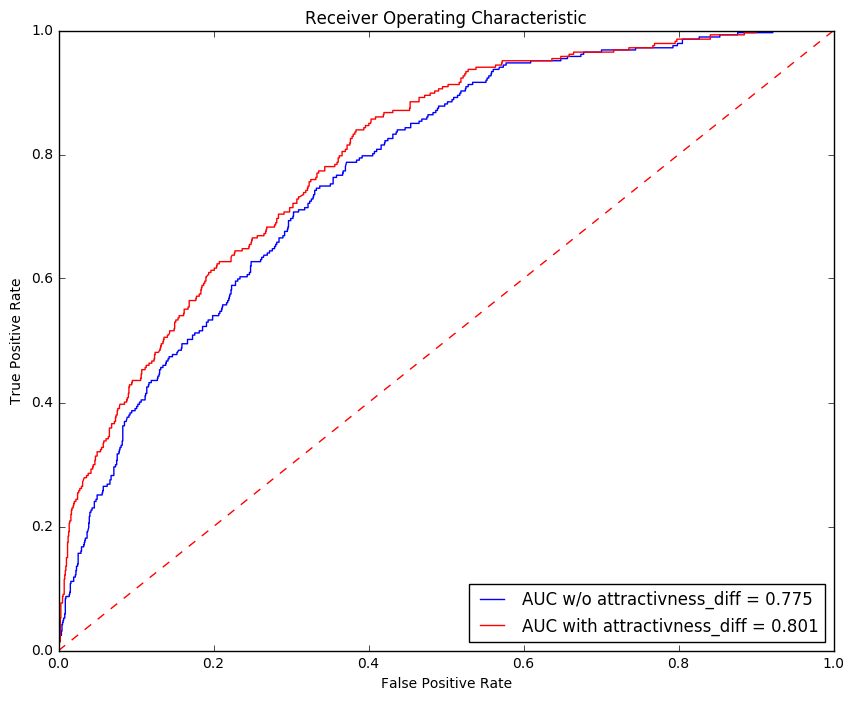

In [201]:
from sklearn.metrics import roc_curve, auc
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 10, 8
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true=y_test,y_score=output)
roc_auc = auc(false_positive_rate, true_positive_rate)

false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_true=y_test,y_score=output2)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC w/o attractivness_diff = %0.3f'% roc_auc)
plt.plot(false_positive_rate2, true_positive_rate2, 'r', label='AUC with attractivness_diff = %0.3f'% roc_auc2)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

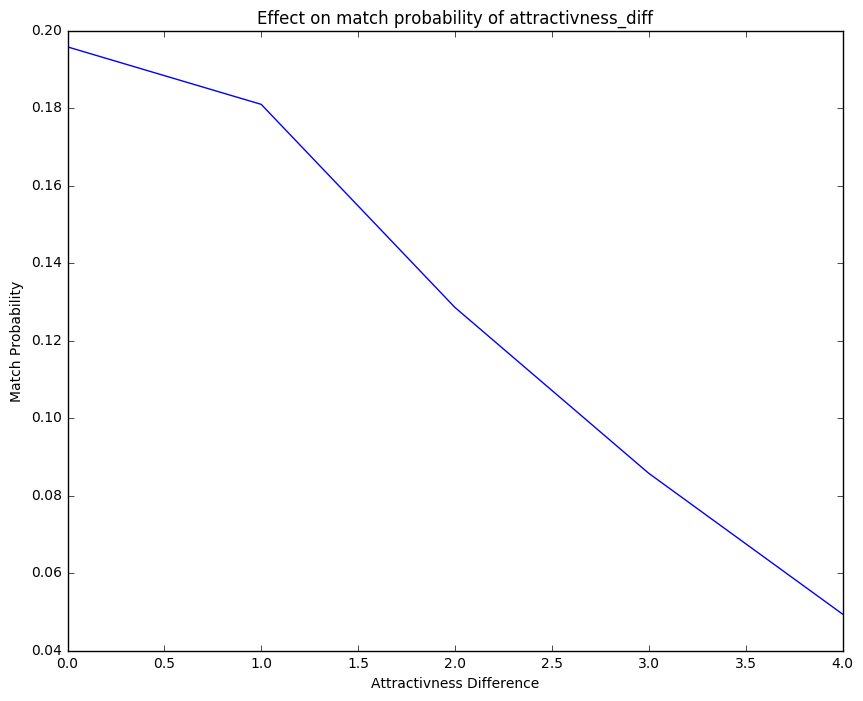

In [203]:
test_person=df[["imprace","imprelig","attr_o","sinc_o","fun_o","amb_o","like_o","prob_o","age_diff","attractiveness_diff"]].iloc[0]
x=[]
y=[]
for j in range (0,5):
    avg=0
    for i in range (0,8377):
        test_person=df[["imprace","imprelig","attr_o","sinc_o","fun_o","amb_o","like_o","prob_o","age_diff","attractiveness_diff"]].iloc[i]
        test_person["attractiveness_diff"]=j
        avg=avg+gb.predict_proba(test_person.reshape(1,-1))[0][1]
    y.append(float(avg/8377))
    x.append(j)
plt.title("Effect on match probability of attractivness_diff")
plt.xlabel("Attractivness Difference")
plt.ylabel("Match Probability")
plt.plot(x,y)

In [188]:
test_person=df[["imprace","imprelig","attr_o","sinc_o","fun_o","amb_o","like_o","prob_o","age_diff","attr3_1","sinc3_1","fun3_1","intel3_1","amb3_1","attractiveness_diff"]].iloc[0]
test_person

imprace                2.0
imprelig               4.0
attr_o                 6.0
sinc_o                 8.0
fun_o                  8.0
amb_o                  8.0
like_o                 7.0
prob_o                 4.0
age_diff               6.0
attr3_1                6.0
sinc3_1                8.0
fun3_1                 8.0
intel3_1               8.0
amb3_1                 7.0
attractiveness_diff    1.1
Name: 0, dtype: float64

In [189]:
df.tail()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,attractiveness_diff,age_diff
8373,552,22.000000,1,44,2,21,22,14,10.0,5,18,526,0,0.64,0,26.0,3.0,10.0,10.0,30.0,20.0,10.0,15.00000,1,10.0,5.0,3.0,2.0,6.0,5.0,6.0,1.0,1.960215,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it...,15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,5.570556,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0,0,3.0,5.0,5.0,5.0,6.734997,5.425138,2.0,5.0,0.0,3.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,5.0,1.0,2.0,70.0,0.0,15.0,10.0,0.0,5.0,70.0,0.0,15.0,10.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0,10.0,50.0,5.0,10.0,20.0,5.0,10.0,9.0,3.0,7.0,6.0,9.0,9.0,3.0,9.0,4.0,7.0,2.0,0.0,0.0,1.230615,1.0,70.0,0.0,20.0,10.0,0.0,0.0,70.0,0.0,20.0,10.0,0.0,0.0,80.0,0.0,10.0,0.0,0.0,10.0,50.0,5.0,10.0,20.0,10.0,5.0,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0,2.750000,1.0
8374,552,22.000000,1,44,2,21,22,13,10.0,4,19,527,0,0.71,0,24.0,6.0,50.0,20.0,10.0,5.0,10.0,5.00000,0,6.0,3.0,7.0,3.0,7.0,2.0,2.0,2.0,2.000000,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it...,15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,5.570556,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.0,7.0,7.0,9.0,7.0,10.0,5.0,9.0,0,4.0,6.0,8.0,4.0,4.000000,5.425138,4.0,4.0,0.0,3.0,22.635849,14.4,16.422642,14.092075,9.268868,11.329245,7.082249,7.978959,8.164499,7.612471,7.50153,5.0,1.0,2.0,70.0,0.0,15.0,10.0,0.0,5.0,70.0,0.0,15.0,10.0,0.0,5.0,80.0,0.0,5.0,5.0,0.0,10.0,50.0,5.0,10.0,20.0,5.0,10.0,9.0,3.0,7.0,6.0,9.0,9.0,3.0,9.0,4.0,7.0,2.0,0.0,0.0,1.230615,1.0,70.0,0.0,20.0,10.0,0.0,0.0,70.0,0.0,20.0,10.0,0.0,0.0,80.0,0.0,10.0,0.0,0.0,10.0,50.0,5.0,10.0,20.0,10.0,5.0,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0,2.395238,1.0
8375,552,22.000000,1,44,2,21,22,19,10.0,10,20,528,0,-0.46,0,29.0,3.0,40.0,10.0,30.0,10.0,10.0,11.84593,0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.000000,25.0,Climate Dynamics,18.0,"Ecole Normale Suprieure, Paris",NaN,NaN,2.0,1.0,1.0,France,"78,110",NaN,1.0,2.0,1.0,assistant master of the universe (otherwise it...,15.0,8.0,2.0,5.0,10.0,10.0,10.0,7.0,1.0,9.0,8.0,3.0,7.0,9.0,10.0,10.0,7.0,3.0,10.0,5.570556,70.0,0.0,15.0,15.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,10.0,50.0,0.0,0.0,30.0,0.0,20.0,8.0,7.0,6.